In [67]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import importlib
from paddleocr import PaddleOCR
import json
import os
import sys
from skimage.transform import rotate
from skimage.feature import local_binary_pattern
from skimage.color import label2rgb

sys.path.append("..")

# Add Python modules here which you are working with, so that you can reload them
# without need of restarting the kernel.
import src.evaluation as evaluation
import src.count_features as count_features
import src.extract_color as extract_color
_ = importlib.reload(extract_color)
_ = importlib.reload(evaluation)
_ = importlib.reload(count_features)
from src.count_features import draw_bounding_boxes, compute_feature_counts, filter_by_feature_count
from src.evaluation import evaluate_filter_functions
from src.extract_color import extract_color,euclidean_Dist,filter_by_color
from src.load_data import load_and_process_eTRIMS

print("Numpy version:", np.__version__)
print("OpenCV version:", cv2.__version__)

Numpy version: 1.26.3
OpenCV version: 4.6.0


In [68]:
eTRIMS_annotations_folder = "../data/etrims-db_v1/annotations_08etrims-ds"
eTRIMS_images_folder = "../data/etrims-db_v1/images_08_etrims-ds"

image_data = load_and_process_eTRIMS(eTRIMS_annotations_folder, eTRIMS_images_folder)

<Figure size 640x480 with 0 Axes>

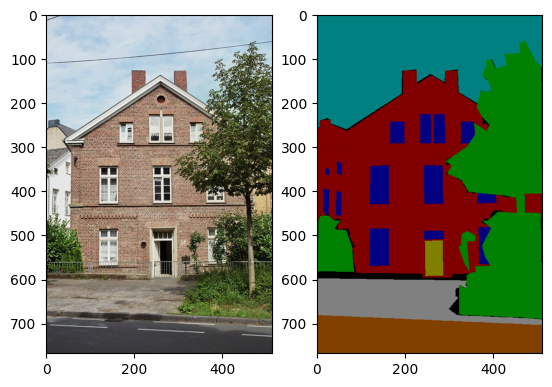

In [69]:
image_name = 'bonn_000047'

plt.figure()
# rows, columns
f, axarr = plt.subplots(1,2)
axarr[0].imshow(image_data[image_name].image)
axarr[1].imshow(image_data[image_name].annotation)
plt.show()

In [70]:
# LBP settings
radius = 2
n_points = 8 * radius

In [71]:
lbp_data = {}
for img_name, img_data in image_data.items():
    image = cv2.cvtColor(img_data.image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(image, n_points, radius, method='uniform')
    lbp_data[img_name] = lbp

Text(0, 0.5, 'Percentage')

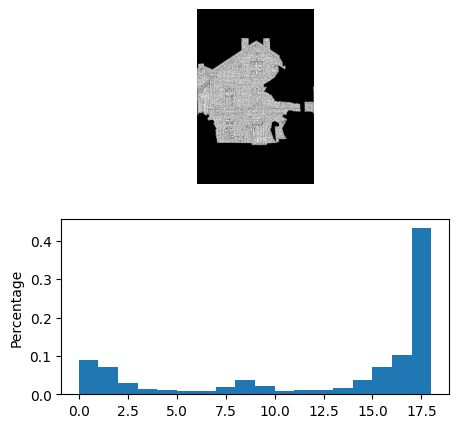

In [72]:
lbp = lbp_data[image_name]

building_mask = image_data[image_name].masks['building'].astype(bool)
windows_mask = image_data[image_name].masks['window'].astype(bool)
door_mask = image_data[image_name].masks['door'].astype(bool)
mask = building_mask | windows_mask | door_mask

building_mask = image_data[image_name].masks['building'].astype(np.uint8)
windows_mask = image_data[image_name].masks['window'].astype(np.uint8)
door_mask = image_data[image_name].masks['door'].astype(np.uint8)
mask_as_int = building_mask | windows_mask | door_mask
masked = cv2.bitwise_and(lbp, lbp, mask=mask_as_int)

fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=1, figsize=(5, 5))
plt.gray()
ax_img.imshow(masked)
ax_img.axis('off')
n_bins = int(lbp.max() + 1)
ax_hist.hist(lbp[mask], density=True, bins=n_bins, range=(0, n_bins))
ax_hist.set_ylabel('Percentage')

In [73]:
def kullback_leibler_divergence(p, q):
    p = np.asarray(p)
    q = np.asarray(q)
    filt = np.logical_and(p != 0, q != 0)
    return np.sum(p[filt] * np.log2(p[filt] / q[filt]))

def scores(original_data, lbp_data, image_name):
    score_dict = {}

    lbp = lbp_data[image_name]

    building_mask = original_data[image_name].masks['building'].astype(bool)
    windows_mask = original_data[image_name].masks['window'].astype(bool)
    door_mask = original_data[image_name].masks['door'].astype(bool)
    mask = building_mask | windows_mask | door_mask

    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp[mask], density=True, bins=n_bins, range=(0, n_bins))

    for name, ref in lbp_data.items():
        building_mask = original_data[name].masks['building'].astype(bool)
        windows_mask = original_data[name].masks['window'].astype(bool)
        door_mask = original_data[name].masks['door'].astype(bool)
        mask = building_mask | windows_mask | door_mask

        ref_hist, _ = np.histogram(ref[mask], density=True, bins=n_bins, range=(0, n_bins))
        score = kullback_leibler_divergence(hist, ref_hist)
        score_dict[name] = score
    return score_dict

In [74]:
score_dict = scores(image_data, lbp_data, image_name)

top_8_matches = sorted(score_dict.items(), key=lambda x: x[1])[:8]
worst_8_matches = sorted(score_dict.items(), key=lambda x: x[1], reverse=True)[:8]

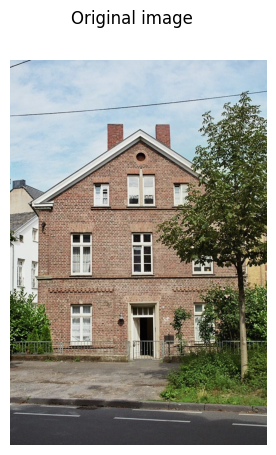

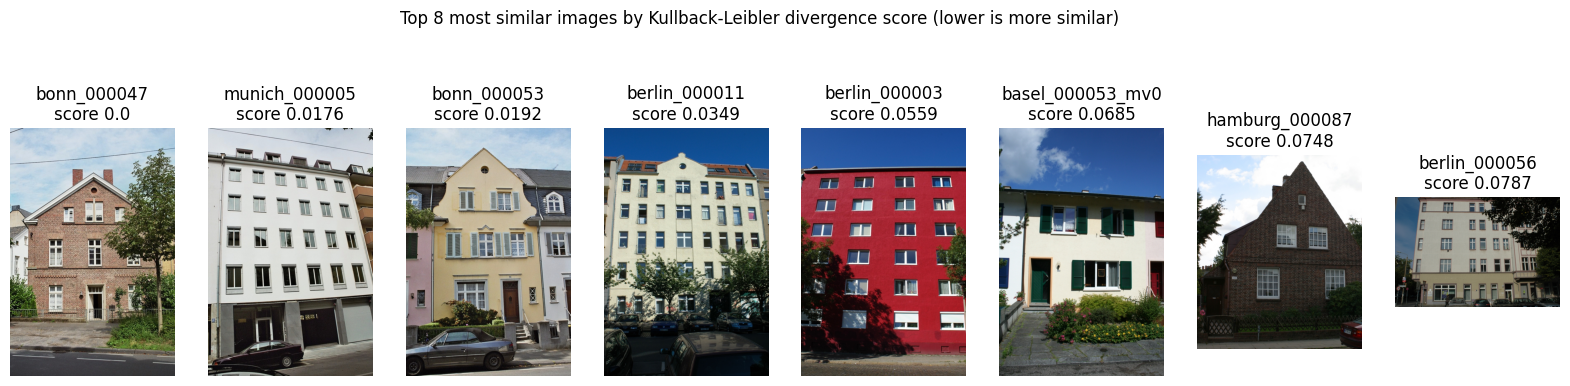

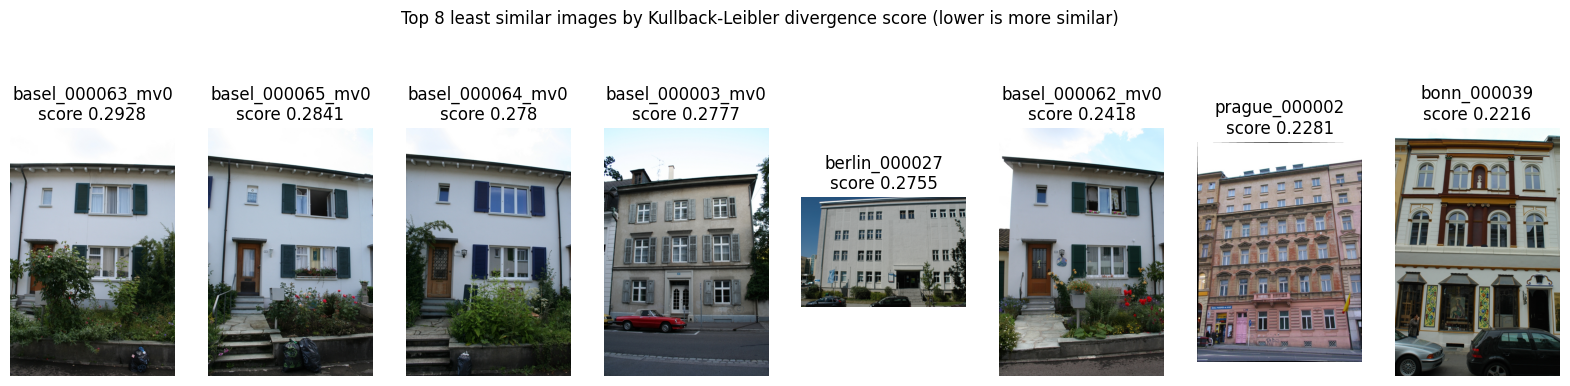

In [75]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
fig.suptitle('Original image')
ax.imshow(image_data[image_name].image)
ax.axis('off')
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(20,5))
fig.suptitle('Top 8 most similar images by Kullback-Leibler divergence score (lower is more similar)')
for i, (name, score) in enumerate(top_8_matches):
    ax[i].imshow(image_data[name].image)
    ax[i].axis('off')
    ax[i].set_title(f'{name}\nscore {round(score, 4)}')
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(20,5))
fig.suptitle('Top 8 least similar images by Kullback-Leibler divergence score (lower is more similar)')
for i, (name, score) in enumerate(worst_8_matches):
    ax[i].imshow(image_data[name].image)
    ax[i].axis('off')
    ax[i].set_title(f'{name}\nscore {round(score, 4)}')
plt.show()

# Main

### Filter by building texture

In [ ]:
image_name = 'bonn_000047'

# LBP settings
radius = 2
n_points = 8 * radius

In [ ]:
lbp_data = {}
for img_name, img_data in image_data.items():
    image = cv2.cvtColor(img_data.image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(image, n_points, radius, method='uniform')
    lbp_data[img_name] = lbp

In [ ]:
lbp = lbp_data[image_name]

building_mask = image_data[image_name].masks['building'].astype(bool)
windows_mask = image_data[image_name].masks['window'].astype(bool)
door_mask = image_data[image_name].masks['door'].astype(bool)
mask = building_mask | windows_mask | door_mask

building_mask = image_data[image_name].masks['building'].astype(np.uint8)
windows_mask = image_data[image_name].masks['window'].astype(np.uint8)
door_mask = image_data[image_name].masks['door'].astype(np.uint8)
mask_as_int = building_mask | windows_mask | door_mask
masked = cv2.bitwise_and(lbp, lbp, mask=mask_as_int)

fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=1, figsize=(5, 5))
plt.gray()
ax_img.imshow(masked)
ax_img.axis('off')
n_bins = int(lbp.max() + 1)
ax_hist.hist(lbp[mask], density=True, bins=n_bins, range=(0, n_bins))
ax_hist.set_ylabel('Percentage')

In [ ]:
def kullback_leibler_divergence(p, q):
    p = np.asarray(p)
    q = np.asarray(q)
    filt = np.logical_and(p != 0, q != 0)
    return np.sum(p[filt] * np.log2(p[filt] / q[filt]))

def scores(original_data, lbp_data, image_name):
    score_dict = {}

    lbp = lbp_data[image_name]

    building_mask = original_data[image_name].masks['building'].astype(bool)
    windows_mask = original_data[image_name].masks['window'].astype(bool)
    door_mask = original_data[image_name].masks['door'].astype(bool)
    mask = building_mask | windows_mask | door_mask

    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp[mask], density=True, bins=n_bins, range=(0, n_bins))

    for name, ref in lbp_data.items():
        building_mask = original_data[name].masks['building'].astype(bool)
        windows_mask = original_data[name].masks['window'].astype(bool)
        door_mask = original_data[name].masks['door'].astype(bool)
        mask = building_mask | windows_mask | door_mask

        ref_hist, _ = np.histogram(ref[mask], density=True, bins=n_bins, range=(0, n_bins))
        score = kullback_leibler_divergence(hist, ref_hist)
        score_dict[name] = score
    return score_dict

In [ ]:
score_dict = scores(image_data, lbp_data, image_name)

top_8_matches = sorted(score_dict.items(), key=lambda x: x[1])[:8]
worst_8_matches = sorted(score_dict.items(), key=lambda x: x[1], reverse=True)[:8]

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
fig.suptitle('Original image')
ax.imshow(image_data[image_name].image)
ax.axis('off')
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(20,5))
fig.suptitle('Top 8 most similar images by Kullback-Leibler divergence score (lower is more similar)')
for i, (name, score) in enumerate(top_8_matches):
    ax[i].imshow(image_data[name].image)
    ax[i].axis('off')
    ax[i].set_title(f'{name}\nscore {round(score, 4)}')
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(20,5))
fig.suptitle('Top 8 least similar images by Kullback-Leibler divergence score (lower is more similar)')
for i, (name, score) in enumerate(worst_8_matches):
    ax[i].imshow(image_data[name].image)
    ax[i].axis('off')
    ax[i].set_title(f'{name}\nscore {round(score, 4)}')
plt.show()